In [144]:
import numpy as np
from matplotlib import pyplot as plt
import SimpleITK as sitk
import pickle as pkl
import torch

import time
from collections import deque


from force_control import z_force_control

import sys
sys.path.append("../../")

from scripts.SurfaceContact.move import move_default_pose

from scripts.USImageCV.utils.bunny import bunny_mask_predict, load_bunny_model,max_connected_area
%load_ext autoreload
%autoreload 2
import cv2
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [146]:

device = 'cuda' if torch.cuda.is_available() else 'cpu'

vessel_model = load_bunny_model('../../scripts/USImageCV/model_weights/vessel_model.pth',device)

# Visualize registration result

In [192]:

import pickle as pkl
from cv2 import cvtColor

def to_grayscale(img):
    original_shape = img.shape[:2]
    img = cvtColor(img,cv2.COLOR_BGR2GRAY).astype(float)
    img /= np.max(img)
    return img
def centroid3(img):
    nx, ny, nz = img.shape
    # print(nx,ny,nz)
    imgx = np.sum(np.sum(img, axis=1), axis=1)
    imgy = np.sum(np.sum(img, axis=2), axis=0)
    imgz = np.sum(np.sum(img, axis=0), axis=0)
    denom = np.sum(np.sum(np.sum(img, axis=0), axis=0), axis=0)
    cx = np.sum(np.linspace(0, nx-1, nx)*imgx)/denom
    cy = np.sum(np.linspace(0, ny-1, ny)*imgy)/denom
    cz = np.sum(np.linspace(0, nz-1, nz)*imgz)/denom
    
    return cx, cy, cz

def get_slice_at(img, coord):
    img = sitk.GetArrayViewFromImage(img).astype(float)
    img = np.swapaxes(img,0,2)
    l,p,s = coord
    
    return img[:,:,s]
def plot_img_at(img, coord, label='Target Location',
    vmin = 0.4,
    vmax = 0.8,ax=None):
    '''
        Plot the 3D slicing view of img at coord.
    '''
    img = np.array(img)
    img += -np.min(img)
    img /= np.max(img)
   
    l,p,s = coord
    
    
    target_marker = 'x'
    target_size = 50
    target_color = 'yellow'

  
    if ax is None:
        ax = plt.gca()
    ax.axis('off')
    
    # Only plot the horizontal slice.
    ax.imshow(np.squeeze(img[:,:,s]).T,cmap='gray',vmin=vmin,vmax=vmax)
    ax.scatter(l,p,marker = target_marker,s=target_size,color = target_color,label=label)
    ax.legend()    
    return ax
def visualize_body(img,target_pixel=None,label=None,
                    vmin = 0.4,
                    vmax = 0.8,ax=None):
    img = sitk.GetArrayViewFromImage(img).astype(float)
    img = np.swapaxes(img,0,2)
    if target_pixel is None:
        target_pixel = np.array(centroid3(img))
        label = 'Centroid location'
    plot_img_at(img,np.array(target_pixel,dtype=int),label,vmin,vmax,ax)
    
    
def flip_img(input_img,orders):
    flipped_ct = sitk.Flip(input_img,orders)
    flipped_ct = sitk.GetImageFromArray(sitk.GetArrayFromImage(flipped_ct).astype(np.float64))
    flipped_ct.SetOrigin(input_img.GetOrigin())
    flipped_ct.SetSpacing(input_img.GetSpacing())
    return flipped_ct

In [11]:
with open('us_observations.pkl','rb') as fp:
    data = pkl.load(fp)
target_locs = data['CT_target_locs']
origin = data['Observation Origin']
frames = data['frame']
body_ct = sitk.ReadImage('./nifty/CT_phantom_regular.nii.gz')
body_ct = flip_img(body_ct,[True,False,False])
vessel_ct = sitk.ReadImage('./nifty/vessel_ct.nii.gz')
vessel_ct = flip_img(vessel_ct,[True,False,False])

In [116]:
import yaml
with open('../../config/us_spacing.yaml') as fp:
    sp = yaml.safe_load(fp)

# Spacing Units are mm.
xspacing = sp['xspacing'] 
yspacing = sp['yspacing']

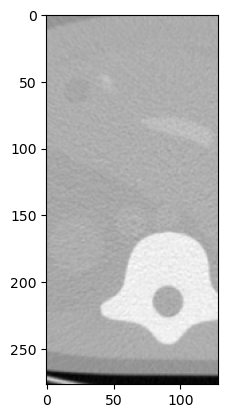

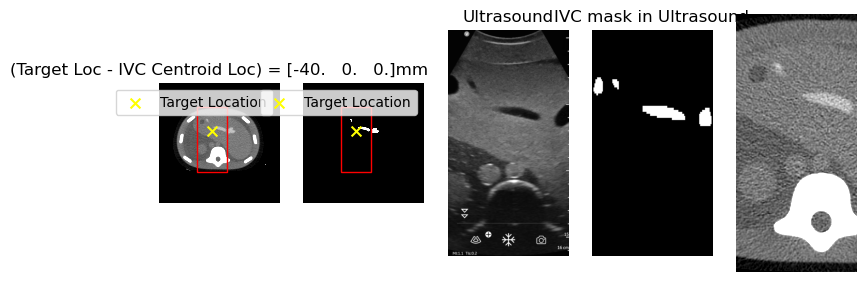

In [179]:
def draw_us_box(ax,l,t,w,h):
    '''
        l is the coordinate for the center of the box.
        t is the coordinate for the top of the box.
        w, h are the width, height of the box.
    '''
    rect = patches.Rectangle((l-w/2,t), w, h, linewidth=1, edgecolor='r', facecolor='none',label='US field of view')
    # Add the patch to the Axes
    ax.add_patch(rect)
    return ax
i = 0
loc = target_locs[7]
frame = frames[7]

plt.figure(figsize=(9,6))

pix = body_ct.TransformPhysicalPointToIndex(loc)
ax = plt.subplot(1,5,1)
visualize_body(body_ct,pix,'Target Location',vmin=0.6,vmax=0.8,ax=ax)


# Only plot the horizontal slice.
img = sitk.GetArrayViewFromImage(body_ct).astype(float)
img = np.swapaxes(img,0,2)
img = np.array(img)
img += -np.min(img)
img /= np.max(img)
l,p,s = pix
slice = np.squeeze(img[:,:,s]).T
t = upper_boundary(slice,l)
w,h = np.array(vessel_us.GetSize()[:2])*np.array([xspacing,yspacing])/np.array(vessel_ct.GetSpacing()[:2])
draw_us_box(ax,l,t,w,h)

ax.set_title('(Target Loc - IVC Centroid Loc) = {}mm'.format(loc-origin))

ax = plt.subplot(1,5,2)
visualize_body(vessel_ct,pix,'Target Location',vmin=0.6,vmax=0.8,ax=ax)
draw_us_box(ax,l,t,w,h)


ax = plt.subplot(1,5,3)
ax.axis('off')
ax.imshow(to_grayscale(frame[100:1040]),cmap = 'gray')
ax.set_title('Ultrasound')

ax = plt.subplot(1,5,4)
pred_mask = bunny_mask_predict(vessel_model,frame,device)
ax.axis('off')
ax.imshow(pred_mask[100:1040],cmap = 'gray')
ax.set_title('IVC mask in Ultrasound')

plt.subplot(1,5,5)
plt.axis('off')
plt.imshow(slice[t:int(t+h),int(l-w/2):int(l+w/2)],cmap='gray',vmin = 0.6,vmax=0.8)

plt.show()
i+=1


In [280]:
def centroid2(img):
    nx, ny = img.shape
    print(nx,ny)
    
    imgx = np.sum(img, axis=1)
    imgy = np.sum(img, axis=0)

    denom = np.sum(img)
    
    cx = np.sum(np.linspace(0, nx-1, nx)*imgx)/denom
    cy = np.sum(np.linspace(0, ny-1, ny)*imgy)/denom
    
    return cx, cy

def normalize_vessel_slice(input_img):
    img = sitk.GetArrayViewFromImage(input_img)
    
    output_spacing = np.array([1.0,1.0])
    output_size = (np.array(input_img.GetSize())*np.array(input_img.GetSpacing())/output_spacing).astype(np.uint32).tolist()
    output_origin = input_img.GetOrigin()

    identity_tf = sitk.Euler2DTransform() # We only crop and change the resolution of the image. No spatial transform is needed.
    return sitk.Resample(input_img,output_size, identity_tf, sitk.sitkLinear,output_origin,output_spacing)
    

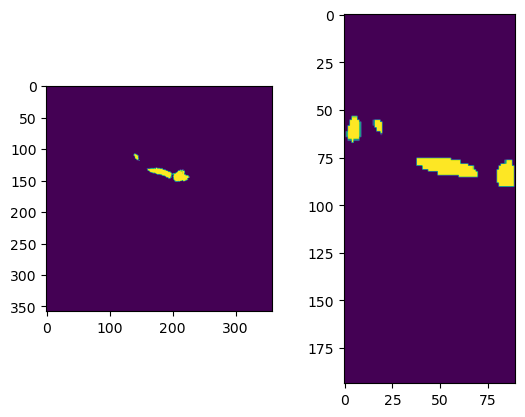

In [283]:
# Standardize the resolution for US and CT vessel slice images.
plt.subplot(1,2,1)
vessel_ct_slice = get_slice_at(vessel_ct,pix)

vessel_ct_slice = sitk.GetImageFromArray(vessel_ct_slice)
vessel_ct_slice.SetSpacing(vessel_ct.GetSpacing()[:2])

o = sitk.GetArrayFromImage(normalize_vessel_slice(vessel_ct_slice))
plt.imshow(o.T)

plt.subplot(1,2,2)
vessel_us_slice = pred_mask.T
vessel_us_slice = sitk.GetImageFromArray(vessel_us_slice)
vessel_us_slice.SetSpacing([xspacing,yspacing])

o = sitk.GetArrayFromImage(normalize_vessel_slice(vessel_us_slice))
plt.imshow(o.T)
plt.show()

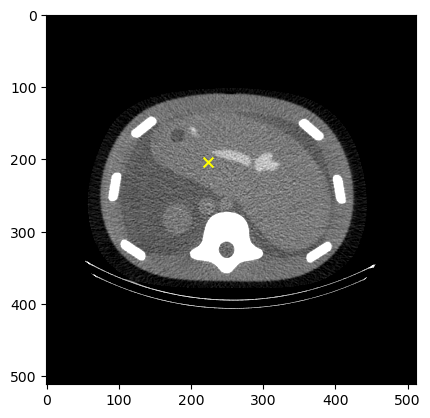

In [228]:

coord = pix
img = body_ct
vmin=0.6
vmax=0.8

img = sitk.GetArrayViewFromImage(img).astype(float)
img = np.swapaxes(img,0,2)

img = np.array(img)
img += -np.min(img)
img /= np.max(img)

l,p,s = coord

# axis_label ={"L":"L: left to right",
#              "P":"P: front to back",
#              "S":"S: feet to head"}
    

target_marker = 'x'
target_size = 50
target_color = 'yellow'


ax = plt.gca()

# Only plot the horizontal slice.
slice = np.squeeze(img[:,:,s]).T
ax.imshow(slice,cmap='gray',vmin=vmin,vmax=vmax)
ax.scatter(l,p,marker = target_marker,s=target_size,color = target_color)

In [136]:
def upper_boundary(slice,l): 
    m = np.argwhere(slice[:,l]>=0.6)
    if len(m)>0:
        return m[0,0]
    else:
        return np.inf



In [124]:
w,h = np.array(vessel_us.GetSize()[:2])*np.array([xspacing,yspacing])/np.array(vessel_ct.GetSpacing()[:2])


In [129]:
(t, t-w/2)

(101, 36.68856004352391)

In [130]:
w,h

(128.6228799129522, 277.8254206119767)

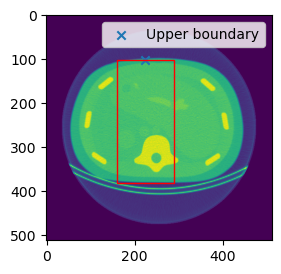

In [137]:
from matplotlib import patches
plt.subplot(1,2,1)
plt.imshow(slice)

plt.scatter(l,upper_boundary(slice,l) ,marker = "x",label = 'Upper boundary')

t = upper_boundary(slice,l)
w,h = np.array(vessel_us.GetSize()[:2])*np.array([xspacing,yspacing])/np.array(vessel_ct.GetSpacing()[:2])
# Create a Rectangle patch
rect = patches.Rectangle((l-w/2,t), w, h, linewidth=1, edgecolor='r', facecolor='none')
# Add the patch to the Axes
ax = plt.gca()
ax.add_patch(rect)

# x = np.arange(slice.shape[1])
# plt.scatter(x,[upper_boundary(slice,i) for i in x] ,marker = "x",label = 'Upper boundary')
plt.legend()

plt.show()